In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance


file_path = '/home/felipe.castanogonzal/ENEL645/finalproject/database/ChfSynthData-13_09_2024.parquet'
df = pd.read_parquet(file_path)
df.head()

,Id,IdLinked,FirstName,LastName,DobDay,DobMonth,DobYear,FirstName_q2f32,FirstName_q3f32,FirstName_q2f64,...,DobDay_q2f64,DobDay_q3f64,DobMonth_q2f32,DobMonth_q3f32,DobMonth_q2f64,DobMonth_q3f64,DobYear_q2f32,DobYear_q3f32,DobYear_q2f64,DobYear_q3f64
1070,1070,1070,michaela,neumann,11,11,1915,1476475386,2358380130,1729691598708548002,...,1374657979648,144115737848446978,268444992,50331778,1374657979648,144115737848446978,1514144160,2433810956,1152921643559944576,4505852622995456
1016,1016,1016,courtney,painter,14,12,1916,2224482715,325614675,9224570002094598168,...,13195481972992,140739640033408,805835136,1141113344,550561648896,1128100070948864,1481638148,285287972,580964353411383556,6614534922272
4405,4405,4405,charles,green,30,9,1948,178393390,371070729,621497908260376610,...,578712827029618704,2305845208236982288,536880384,262272,2305847407260213504,1125899906842752,483467520,50339846,311029849676325120,216207992272453636
1288,1288,1288,vanessa,parr,19,11,1995,1622467657,3300159584,2316121283648053312,...,2305843009616355584,567220895744,268444992,50331778,1374657979648,144115737848446978,3641704864,18221204,4616189758060626304,4513031392722944
3585,3585,3585,mikayla,malloney,8,2,1986,1351166346,3087353378,5803179534740103296,...,295267250569478144,4611686018427387905,603992064,16896,288230376688594944,16896,403769100,16790580,4789507412984580,22007429210160


**Clean the database**

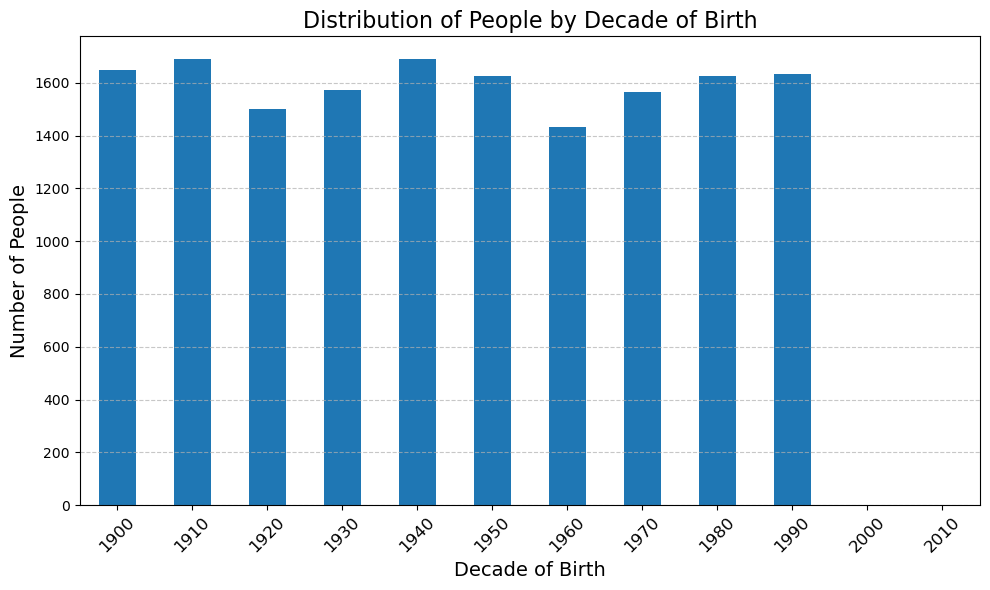

In [2]:
# Select only the specified columns to keep
filtered_data = df[["Id", "IdLinked", "FirstName", "LastName", "DobDay", "DobMonth", "DobYear"]]

# Check for empty cells in each column
missing_data_summary = filtered_data.isnull().sum()
missing_data_summary

# Convert DobYear to integers
filtered_data.loc[:, 'DobYear'] = pd.to_numeric(filtered_data['DobYear'], errors='coerce')

# Drop rows where DobYear could not be converted to numeric
filtered_data = filtered_data.dropna(subset=['DobYear'])
filtered_data['DobYear'] = filtered_data['DobYear'].astype(int)

# Group the years into decades for easier visualization
filtered_data['Decade'] = (filtered_data['DobYear'] // 10) * 10

# Create a distribution plot for the decades
plt.figure(figsize=(10, 6))
filtered_data['Decade'].value_counts().sort_index().plot(kind='bar')

# Customize the plot
plt.title('Distribution of People by Decade of Birth', fontsize=16)
plt.xlabel('Decade of Birth', fontsize=14)
plt.ylabel('Number of People', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

**Quick Analysis** 

In [3]:
# Determine unique and duplicated records
unique_records = filtered_data[filtered_data['Id'] == filtered_data['IdLinked']]
duplicated_records = filtered_data[filtered_data['Id'] != filtered_data['IdLinked']]

# Count unique and duplicated records
unique_count = len(unique_records)
duplicated_count = len(duplicated_records)

unique_count, duplicated_count

(4750, 11241)

In [4]:
# Select only the specified columns for the unique and duplicated records datasets
columns_to_keep = ["FirstName", "LastName", "DobDay", "DobMonth", "DobYear"]

# Create the datasets
unique_dataset = unique_records[columns_to_keep].reset_index(drop=True)
duplicated_dataset = duplicated_records[columns_to_keep].reset_index(drop=True)

# Save the datasets for inspection or further use
unique_dataset_path = '/home/felipe.castanogonzal/ENEL645/finalproject/database/unique_records.csv'
duplicated_dataset_path = '/home/felipe.castanogonzal/ENEL645/finalproject/database/duplicated_records.csv'

unique_dataset.to_csv(unique_dataset_path, index=False)
duplicated_dataset.to_csv(duplicated_dataset_path, index=False)

unique_dataset_path, duplicated_dataset_path
unique_dataset.head(), duplicated_dataset.head()

(  FirstName  LastName DobDay DobMonth  DobYear
 0  michaela   neumann     11       11     1915
 1  courtney   painter     14       12     1916
 2   charles     green     30        9     1948
 3   vanessa      parr     19       11     1995
 4   mikayla  malloney      8        2     1986,
   FirstName  LastName DobDay DobMonth  DobYear
 0  michaela   neumann     11       11     1915
 1  michaela  neumannl     11       11     1915
 2  michaela        ne     11       11     1955
 3  michaela   neumann      7       11     1960
 4       cha     green     30        9     1948)

In [11]:
# Determine unique and duplicated records
unique_records = filtered_data[filtered_data['Id'] == filtered_data['IdLinked']]
duplicated_records = filtered_data[filtered_data['Id'] != filtered_data['IdLinked']]

# Organize the database: unique records first, followed by their duplicates
organized_data = pd.concat([unique_records, duplicated_records]).sort_values(by=['IdLinked', 'Id']).reset_index(drop=True)

# Count the number of duplicates for each unique record, excluding the unique record itself
duplicate_counts = (
    duplicated_records.groupby('IdLinked').size().reset_index(name='DuplicateCount')
)

# Merge the duplicate counts back into the organized_data
organized_data = organized_data.merge(duplicate_counts, how='left', left_on='IdLinked', right_on='IdLinked')

# Fill NaN values in DuplicateCount with 0 for unique records and duplicates without counts
organized_data['DuplicateCount'] = organized_data['DuplicateCount'].fillna(0).astype(int)

# Set 'DuplicateCount' to 0 for duplicated records
organized_data['DuplicateCount'] = organized_data.apply(
    lambda row: row['DuplicateCount'] if row['Id'] == row['IdLinked'] else 0, axis=1
)

# Display the first few rows of the final organized dataset
organized_data.head()

,Id,IdLinked,FirstName,LastName,DobDay,DobMonth,DobYear,Decade,DuplicateCount
0,0,0,rachael,dent,22,7,1928,1920,2
1,1000000,0,rac,dent,22,7,1928,1920,0
2,1010000,0,rachaelintux,dent,22,7,1928,1920,0
3,1,1,isabella,everett,16,8,1911,1910,2
4,1000001,1,isabella,ewfsfut,16,8,1901,1900,0


In [12]:
# Create a new column by concatenating FirstName, LastName, DobDay, DobMonth, and DobYear without spaces
organized_data['FullDetailsOrganized'] = (
    organized_data['FirstName'].astype(str) +
    organized_data['LastName'].astype(str) +
    organized_data['DobDay'].astype(str) +
    organized_data['DobMonth'].astype(str) +
    organized_data['DobYear'].astype(str)
)

# Display the first few rows to verify the new column
organized_data[['FirstName', 'LastName', 'DobDay', 'DobMonth', 'DobYear', 'FullDetailsOrganized']].head()

,FirstName,LastName,DobDay,DobMonth,DobYear,FullDetailsOrganized
0,rachael,dent,22,7,1928,rachaeldent2271928
1,rac,dent,22,7,1928,racdent2271928
2,rachaelintux,dent,22,7,1928,rachaelintuxdent2271928
3,isabella,everett,16,8,1911,isabellaeverett1681911
4,isabella,ewfsfut,16,8,1901,isabellaewfsfut1681901


In [13]:
# Add a new column to mark rows as unique (0) or duplicated (1)
organized_data['IsDuplicated'] = organized_data.apply(
    lambda row: 1 if row['Id'] != row['IdLinked'] else 0, axis=1
)

# Create a new column by concatenating FirstName, LastName, DobDay, DobMonth, and DobYear without spaces or special characters
organized_data['ConcatenatedDetails'] = (
    organized_data['FirstName'].astype(str) +
    organized_data['LastName'].astype(str) +
    organized_data['DobDay'].astype(str) +
    organized_data['DobMonth'].astype(str) +
    organized_data['DobYear'].astype(str)
)

# Create the final dataset with the required columns
final_dataset = organized_data[['ConcatenatedDetails', 'IsDuplicated']]

# Display the first few rows of the final dataset
final_dataset.head()

,ConcatenatedDetails,IsDuplicated
0,rachaeldent2271928,0
1,racdent2271928,1
2,rachaelintuxdent2271928,1
3,isabellaeverett1681911,0
4,isabellaewfsfut1681901,1


In [14]:
unique_dataset['FullDetailsUnique'] = (
    unique_dataset['FirstName'].astype(str) +
    unique_dataset['LastName'].astype(str) +
    unique_dataset['DobDay'].astype(str) +
    unique_dataset['DobMonth'].astype(str) +
    unique_dataset['DobYear'].astype(str)
)
# Add a new column 'IsDuplicated' to the unique_dataset, which will always be 0 since these are unique records
unique_dataset['IsDuplicated'] = 0

# Display the first few rows of the updated unique_dataset
unique_dataset[['FullDetailsUnique', 'IsDuplicated']].head()

,FullDetailsUnique,IsDuplicated
0,michaelaneumann11111915,0
1,courtneypainter14121916,0
2,charlesgreen3091948,0
3,vanessaparr19111995,0
4,mikaylamalloney821986,0


In [15]:
duplicated_dataset['FullDetailsDuplicated'] = (
    duplicated_dataset['FirstName'].astype(str) +
    duplicated_dataset['LastName'].astype(str) +
    duplicated_dataset['DobDay'].astype(str) +
    duplicated_dataset['DobMonth'].astype(str) +
    duplicated_dataset['DobYear'].astype(str)
)
# Add a new column 'IsDuplicated' to the duplicated_dataset, which will always be 1 since these are duplicated records
duplicated_dataset['IsDuplicated'] = 1

# Display the first few rows of the updated duplicated_dataset
duplicated_dataset[['FullDetailsDuplicated', 'IsDuplicated']].head()

,FullDetailsDuplicated,IsDuplicated
0,michaelaneumann11111915,1
1,michaelaneumannl11111915,1
2,michaelane11111955,1
3,michaelaneumann7111960,1
4,chagreen3091948,1


In [16]:
# Drop duplicate column labels to ensure consistency
final_dataset = final_dataset.loc[:, ~final_dataset.columns.duplicated()]
duplicated_dataset = duplicated_dataset.loc[:, ~duplicated_dataset.columns.duplicated()]
unique_dataset = unique_dataset.loc[:, ~unique_dataset.columns.duplicated()]

# Sort all datasets by 'FullDetails' for consistency
final_dataset = final_dataset.sort_values(by='ConcatenatedDetails').reset_index(drop=True)
unique_dataset = unique_dataset.sort_values(by='FullDetailsUnique').reset_index(drop=True)
duplicated_dataset = duplicated_dataset.sort_values(by='FullDetailsDuplicated').reset_index(drop=True)


# Display the first few rows of all datasets to verify consistency
final_dataset

,ConcatenatedDetails,IsDuplicated
0,aabar3031973,1
1,aaliyahottens14121918,0
2,aaliyahottens14121918,1
3,aarobbstovm1931973,1
4,aaronbarsoum3031973,1
...,...,...
15986,zoewastell15121998,0
15987,zoewastell15121998,1
15988,zoewebb17121910,1
15989,zoewebb17121910,0


In [17]:
duplicated_dataset = duplicated_dataset[['FullDetailsDuplicated', 'IsDuplicated']]
duplicated_dataset

,FullDetailsDuplicated,IsDuplicated
0,aabar3031973,1
1,aaliyahottens14121918,1
2,aarobbstovm1931973,1
3,aaronbarsoum3031973,1
4,aaronjhvagcbarsoum3031973,1
...,...,...
11236,zoepaterson1291993,1
11237,zoeszepessy2211933,1
11238,zoewastell15121998,1
11239,zoewebb17121910,1


In [18]:
unique_dataset = unique_dataset[['FullDetailsUnique', 'IsDuplicated']]
unique_dataset

,FullDetailsUnique,IsDuplicated
0,aaliyahottens14121918,0
1,aaronbarsoum3031973,0
2,abbeycoleman1611910,0
3,abbeycolquhoun761996,0
4,abbeycrisci2731989,0
...,...,...
4745,zarranmiles2021909,0
4746,zoepaterson1291993,0
4747,zoeszepessy2211933,0
4748,zoewastell15121998,0


**Bloom Filter**


In [19]:
from hashlib import sha256

# Define a Bloom filter class
class BloomFilter:
    def __init__(self, size=32):
        self.size = size  # Number of bits in the Bloom filter

    def _hash(self, item):
        # Generate a single 64-bit hash value for the item
        hash_value = int(sha256(item.encode('utf-8')).hexdigest(), 16)
        # Map it to a 64-bit space
        return hash_value % (2**32)

# Initialize the Bloom filter
bloom_filter = BloomFilter(size=32)

# Apply the Bloom filter to the FullDetails column
final_dataset['BloomFilter32Bit'] = final_dataset['ConcatenatedDetails'].apply(
    lambda x: bloom_filter._hash(x)
)

# Display the first few rows with the 32-bit numeric Bloom filter representation
print(final_dataset[['ConcatenatedDetails', 'IsDuplicated', 'BloomFilter32Bit']])

          ConcatenatedDetails  IsDuplicated  BloomFilter32Bit
0                aabar3031973             1        1643689933
1       aaliyahottens14121918             0        3567187259
2       aaliyahottens14121918             1        3567187259
3          aarobbstovm1931973             1          48879422
4         aaronbarsoum3031973             1        2877932438
...                       ...           ...               ...
15986      zoewastell15121998             0         539910774
15987      zoewastell15121998             1         539910774
15988         zoewebb17121910             1        3715518538
15989         zoewebb17121910             0        3715518538
15990  zoeyxlepaterson1291993             1        3761702588

[15991 rows x 3 columns]


In [20]:
# Redefine the Bloom filter class and initialize it
class BloomFilter:
    def __init__(self, size=32):
        self.size = size  # Number of bits in the Bloom filter

    def _hash(self, item):
        # Generate a single 32-bit hash value for the item
        hash_value = int(sha256(item.encode('utf-8')).hexdigest(), 16)
        # Map it to a 32-bit space
        return hash_value % (2**32)

# Initialize the Bloom filter
bloom_filter = BloomFilter(size=32)

# Ensure unique_dataset is independent
unique_dataset = unique_dataset.copy()

# Apply the Bloom filter to the FullDetails column in the unique_dataset
unique_dataset['BloomFilter32Bit'] = unique_dataset['FullDetailsUnique'].apply(
    lambda x: bloom_filter._hash(x)
)

# Display the first few rows with the 32-bit numeric Bloom filter representation
unique_dataset[['FullDetailsUnique', 'IsDuplicated', 'BloomFilter32Bit']]

,FullDetailsUnique,IsDuplicated,BloomFilter32Bit
0,aaliyahottens14121918,0,3567187259
1,aaronbarsoum3031973,0,2877932438
2,abbeycoleman1611910,0,3332573822
3,abbeycolquhoun761996,0,1195459061
4,abbeycrisci2731989,0,1502198365
...,...,...,...
4745,zarranmiles2021909,0,3897428547
4746,zoepaterson1291993,0,3921124910
4747,zoeszepessy2211933,0,3393811884
4748,zoewastell15121998,0,539910774


In [21]:
# Redefine the Bloom filter class and initialize it
class BloomFilter:
    def __init__(self, size=32):
        self.size = size  # Number of bits in the Bloom filter

    def _hash(self, item):
        # Generate a single 32-bit hash value for the item
        hash_value = int(sha256(item.encode('utf-8')).hexdigest(), 16)
        # Map it to a 32-bit space
        return hash_value % (2**32)

# Initialize the Bloom filter
bloom_filter = BloomFilter(size=32)

# Ensure unique_dataset is independent
duplicated_dataset = duplicated_dataset.copy()

# Apply the Bloom filter to the FullDetails column in the unique_dataset
duplicated_dataset['BloomFilter32Bit'] = duplicated_dataset['FullDetailsDuplicated'].apply(
    lambda x: bloom_filter._hash(x)
)

# Display the first few rows with the 32-bit numeric Bloom filter representation
duplicated_dataset[['FullDetailsDuplicated', 'IsDuplicated', 'BloomFilter32Bit']]

,FullDetailsDuplicated,IsDuplicated,BloomFilter32Bit
0,aabar3031973,1,1643689933
1,aaliyahottens14121918,1,3567187259
2,aarobbstovm1931973,1,48879422
3,aaronbarsoum3031973,1,2877932438
4,aaronjhvagcbarsoum3031973,1,3293510304
...,...,...,...
11236,zoepaterson1291993,1,3921124910
11237,zoeszepessy2211933,1,3393811884
11238,zoewastell15121998,1,539910774
11239,zoewebb17121910,1,3715518538


In [22]:
# Rename datasets
principal_data = final_dataset.rename(columns={
    'ConcatenatedDetails': 'PrincipalDetails',
    'IsDuplicated': 'IsDuplicated',
    'BloomFilter32Bit': 'BloomFilter32Bit'
})

unique_data = unique_dataset.rename(columns={
    'FullDetailsUnique': 'UniqueDetails',
    'IsDuplicated': 'IsDuplicated',
    'BloomFilter32Bit': 'BloomFilter32Bit'
})

duplicated_data = duplicated_dataset.rename(columns={
    'FullDetailsDuplicated': 'DuplicatedDetails',
    'IsDuplicated': 'IsDuplicated',
    'BloomFilter32Bit': 'BloomFilter32Bit'
})

# Save the datasets to CSV files
principal_data.to_csv('principal_data.csv', index=False)
unique_data.to_csv('unique_data.csv', index=False)
duplicated_data.to_csv('duplicated_data.csv', index=False)

# Confirm file paths for downloading
principal_path = 'principal_data.csv'
unique_path = 'unique_data.csv'
duplicated_path = 'duplicated_data.csv'

principal_data_path = '/home/felipe.castanogonzal/ENEL645/finalproject/database/principal_data.csv'
unique_data_path = '/home/felipe.castanogonzal/ENEL645/finalproject/database/unique_data.csv'
duplicated_data_path = '/home/felipe.castanogonzal/ENEL645/finalproject/database/duplicated_data.csv'

principal_path, unique_path, duplicated_path


('principal_data.csv', 'unique_data.csv', 'duplicated_data.csv')

**Threshold**


In [23]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance

file_paththreshold = '/home/felipe.castanogonzal/ENEL645/finalproject/principal_data.csv'
file_paththreshold1 = '/home/felipe.castanogonzal/ENEL645/finalproject/unique_data.csv'
file_paththreshold2 = '/home/felipe.castanogonzal/ENEL645/finalproject/duplicated_data.csv'
base_data = pd.read_csv(file_paththreshold)
original_data = pd.read_csv(file_paththreshold1)
deduplicated_data = pd.read_csv(file_paththreshold2)

In [24]:
# Sample 500 records from the base data
sampled_data = base_data.sample(n=500, random_state=42)

# Print the sampled data
print(sampled_data)

                    PrincipalDetails  IsDuplicated  BloomFilter32Bit
15980             zoepaterson1291993             0        3921124910
7814             jessicabeams2131904             1        1651423879
150                   adamcra1051927             1         761781273
1684              bertiewhite8101961             1        1526532195
7497   jasminezrkwebbanupxbho1061944             1        4013317649
...                              ...           ...               ...
6554              jackcarbone1411940             1         503599820
6648               jackraward1991980             1        1574844469
12073           nedstephenson1811975             0         735912613
2057            brinleybauman2641936             1         491570036
11416       michaeladunstone18101912             1        3176224164

[500 rows x 3 columns]


In [25]:
# Filter the sampled data to include only rows where IsDuplicated == 0
sampled_unique_data = sampled_data[sampled_data['IsDuplicated'] == 0]

# Print the filtered data
print(sampled_unique_data)

               PrincipalDetails  IsDuplicated  BloomFilter32Bit
15980        zoepaterson1291993             0        3921124910
5206      georgiamaynard2431970             0        3144879481
123      abigailpetersen2511956             0        1764552325
5381       gregorybujtas2101958             0        1950519866
5664   harrisonschuster17111985             0        3864284430
...                         ...           ...               ...
4685      ethanbeckwith13111998             0        2440352264
4786           evankranz2671933             0        3351408033
13445          rubyhentze661903             0         133396855
3617       darcymontfort2281958             0        1536537710
12073      nedstephenson1811975             0         735912613

[154 rows x 3 columns]


In [26]:
# Filter the sampled data to include only rows where IsDuplicated == 0
sampled_duplicate_data = sampled_data[sampled_data['IsDuplicated'] == 1]

# Print the filtered data
print(sampled_duplicate_data)

                    PrincipalDetails  IsDuplicated  BloomFilter32Bit
7814             jessicabeams2131904             1        1651423879
150                   adamcra1051927             1         761781273
1684              bertiewhite8101961             1        1526532195
7497   jasminezrkwebbanupxbho1061944             1        4013317649
1034           angelicacoleman411915             1         447188709
...                              ...           ...               ...
1358              aylacolefax6101961             1         898412731
6554              jackcarbone1411940             1         503599820
6648               jackraward1991980             1        1574844469
2057            brinleybauman2641936             1         491570036
11416       michaeladunstone18101912             1        3176224164

[346 rows x 3 columns]


In [27]:
# Generate all possible comparisons and create a table without indices
comparisons = itertools.combinations(sampled_data['BloomFilter32Bit'], 2)

# Create a list to store comparison results
comparison_table = []

# Populate the table with comparisons
for bloom1, bloom2 in comparisons:
    comparison_table.append({
        "BloomFilter1": bloom1,
        "BloomFilter2": bloom2
    })

# Convert to a DataFrame
comparison_df = pd.DataFrame(comparison_table)

# Print the comparison table
print(comparison_df)


        BloomFilter1  BloomFilter2
0         3921124910    1651423879
1         3921124910     761781273
2         3921124910    1526532195
3         3921124910    4013317649
4         3921124910    3144879481
...              ...           ...
124745    1574844469     491570036
124746    1574844469    3176224164
124747     735912613     491570036
124748     735912613    3176224164
124749     491570036    3176224164

[124750 rows x 2 columns]


In [28]:
# Function to calculate the Dice coefficient between two integers
def dice_coefficient(bf1, bf2):
    # Convert integers to binary strings
    bin1 = bin(bf1)[2:]
    bin2 = bin(bf2)[2:]
    # Pad binary strings to ensure they are the same length
    max_length = max(len(bin1), len(bin2))
    bin1 = bin1.zfill(max_length)
    bin2 = bin2.zfill(max_length)
    # Count matching bits and total bits
    intersection = sum(1 for b1, b2 in zip(bin1, bin2) if b1 == b2 == '1')
    total_bits = len(bin1) + len(bin2)
    # Dice coefficient calculation
    return 2 * intersection / total_bits

# Generate all possible comparisons and calculate the Dice coefficient
comparisons = itertools.combinations(sampled_data['BloomFilter32Bit'], 2)

# Create a list to store comparison results with Dice coefficient
comparison_dice_table = []

# Populate the table with comparisons and Dice coefficients
for bloom1, bloom2 in comparisons:
    dice_value = dice_coefficient(bloom1, bloom2)
    comparison_dice_table.append({
        "BloomFilter1": bloom1,
        "BloomFilter2": bloom2,
        "DiceCoefficient": dice_value
    })

# Convert to a DataFrame
comparison_dice_df = pd.DataFrame(comparison_dice_table)

# Print the comparison table with Dice coefficient
print(comparison_dice_df)


        BloomFilter1  BloomFilter2  DiceCoefficient
0         3921124910    1651423879         0.343750
1         3921124910     761781273         0.375000
2         3921124910    1526532195         0.312500
3         3921124910    4013317649         0.406250
4         3921124910    3144879481         0.375000
...              ...           ...              ...
124745    1574844469     491570036         0.322581
124746    1574844469    3176224164         0.281250
124747     735912613     491570036         0.266667
124748     735912613    3176224164         0.281250
124749     491570036    3176224164         0.281250

[124750 rows x 3 columns]


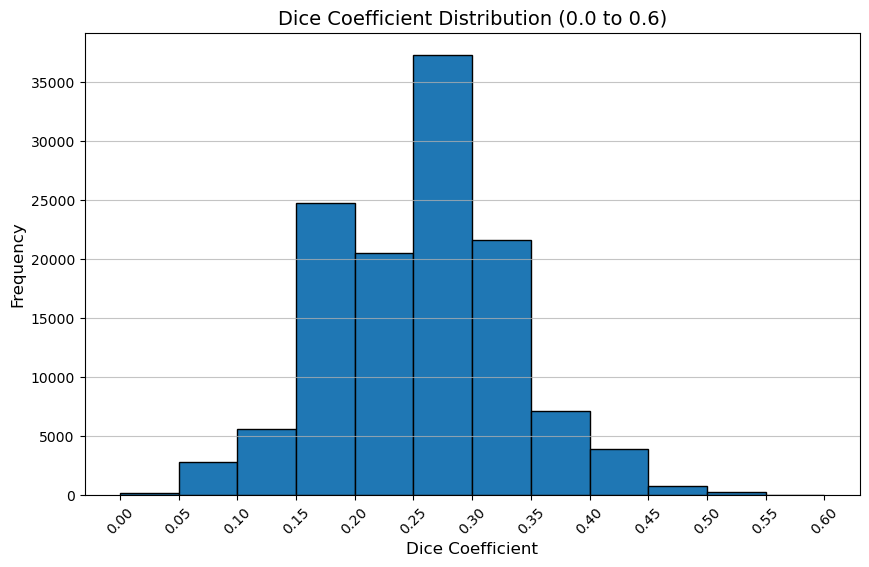

In [29]:
# Plot a histogram of the DiceCoefficient distribution with x-axis limited to 0.0 to 0.6
plt.figure(figsize=(10, 6))
plt.hist(comparison_dice_df['DiceCoefficient'], bins=12, range=(0.0, 0.6), edgecolor='black')  # Adjust range to 0.0 - 0.6
plt.title("Dice Coefficient Distribution (0.0 to 0.6)", fontsize=14)
plt.xlabel("Dice Coefficient", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(ticks=[i * 0.05 for i in range(13)], rotation=45)  # Set x-axis ticks to increments of 0.05
plt.grid(axis='y', alpha=0.75)
plt.show()


In [31]:
# Add a new column with the threshold condition
comparison_dice_df['Threshold_0.4'] = comparison_dice_df['DiceCoefficient'].apply(lambda x: 0 if x > 0.4 else 1)
# Add a new column with the threshold condition
comparison_dice_df['Threshold_0.3'] = comparison_dice_df['DiceCoefficient'].apply(lambda x: 0 if x > 0.3 else 1)
# Add a new column with the threshold condition
comparison_dice_df['Threshold_0.2'] = comparison_dice_df['DiceCoefficient'].apply(lambda x: 0 if x > 0.2 else 1)
# Add a new column with the threshold condition
comparison_dice_df['Threshold_0.1'] = comparison_dice_df['DiceCoefficient'].apply(lambda x: 0 if x > 0.1 else 1)

# Print the updated DataFrame with the new column
comparison_dice_df

,BloomFilter1,BloomFilter2,DiceCoefficient,Threshold_0.4,Threshold_0.3,Threshold_0.2,Threshold_0.1
0,3921124910,1651423879,0.343750,1,0,0,0
1,3921124910,761781273,0.375000,1,0,0,0
2,3921124910,1526532195,0.312500,1,0,0,0
3,3921124910,4013317649,0.406250,0,0,0,0
4,3921124910,3144879481,0.375000,1,0,0,0
...,...,...,...,...,...,...,...
124745,1574844469,491570036,0.322581,1,0,0,0
124746,1574844469,3176224164,0.281250,1,1,0,0
124747,735912613,491570036,0.266667,1,1,0,0
124748,735912613,3176224164,0.281250,1,1,0,0


In [43]:
# Extract the BloomFilter32Bit column from the unique sampled data
unique_bloom_filters = sampled_unique_data['BloomFilter32Bit'].drop_duplicates().values

# Generate all possible pairwise comparisons for the unique Bloom filters
unique_comparisons = itertools.combinations(unique_bloom_filters, 2)

# Create a list to store unique comparison results
unique_comparison_table = []

# Populate the table with comparisons
for bloom1, bloom2 in unique_comparisons:
    unique_comparison_table.append({
        "BloomFilter1": bloom1,
        "BloomFilter2": bloom2
    })

# Convert to a DataFrame
unique_comparison_df = pd.DataFrame(unique_comparison_table)

# Print the unique comparison table
unique_comparison_df

,BloomFilter1,BloomFilter2
0,3921124910,3144879481
1,3921124910,1764552325
2,3921124910,1950519866
3,3921124910,3864284430
4,3921124910,198983665
...,...,...
11776,3351408033,1536537710
11777,3351408033,735912613
11778,133396855,1536537710
11779,133396855,735912613


In [44]:
# Define the Dice coefficient function
def dice_coefficient(bf1, bf2):
    # Convert integers to binary strings
    bin1 = bin(bf1)[2:]
    bin2 = bin(bf2)[2:]
    # Pad binary strings to ensure they are the same length
    max_length = max(len(bin1), len(bin2))
    bin1 = bin1.zfill(max_length)
    bin2 = bin2.zfill(max_length)
    # Count matching bits and total bits
    intersection = sum(1 for b1, b2 in zip(bin1, bin2) if b1 == b2 == '1')
    total_bits = len(bin1) + len(bin2)
    # Dice coefficient calculation
    return 2 * intersection / total_bits

# Add a DiceCoefficient column to the unique_comparison_df
unique_comparison_df['DiceCoefficient'] = unique_comparison_df.apply(
    lambda row: dice_coefficient(row['BloomFilter1'], row['BloomFilter2']),
    axis=1
)

# Print the first few rows of the updated DataFrame
unique_comparison_df


,BloomFilter1,BloomFilter2,DiceCoefficient
0,3921124910,3144879481,0.375000
1,3921124910,1764552325,0.343750
2,3921124910,1950519866,0.281250
3,3921124910,3864284430,0.312500
4,3921124910,198983665,0.312500
...,...,...,...
11776,3351408033,1536537710,0.218750
11777,3351408033,735912613,0.250000
11778,133396855,1536537710,0.354839
11779,133396855,735912613,0.333333


In [46]:
# Add a new column with all zeros
unique_comparison_df['uniquecolumn'] = 0

# Print the updated DataFrame
unique_comparison_df


,BloomFilter1,BloomFilter2,DiceCoefficient,uniquecolumn
0,3921124910,3144879481,0.375000,0
1,3921124910,1764552325,0.343750,0
2,3921124910,1950519866,0.281250,0
3,3921124910,3864284430,0.312500,0
4,3921124910,198983665,0.312500,0
...,...,...,...,...
11776,3351408033,1536537710,0.218750,0
11777,3351408033,735912613,0.250000,0
11778,133396855,1536537710,0.354839,0
11779,133396855,735912613,0.333333,0


In [47]:
# Compare the tables and add a new column to comparison_dice_df
comparison_dice_df['uniquecolumn'] = comparison_dice_df.apply(
    lambda row: unique_comparison_df[
        (unique_comparison_df['BloomFilter1'] == row['BloomFilter1']) &
        (unique_comparison_df['BloomFilter2'] == row['BloomFilter2']) &
        (unique_comparison_df['DiceCoefficient'] == row['DiceCoefficient'])
    ]['uniquecolumn'].values[0]
    if not unique_comparison_df[
        (unique_comparison_df['BloomFilter1'] == row['BloomFilter1']) &
        (unique_comparison_df['BloomFilter2'] == row['BloomFilter2']) &
        (unique_comparison_df['DiceCoefficient'] == row['DiceCoefficient'])
    ].empty else None,
    axis=1
)

# Display the updated comparison_dice_df
comparison_dice_df.head()


,BloomFilter1,BloomFilter2,DiceCoefficient,Threshold_0.4,Threshold_0.3,Threshold_0.2,Threshold_0.1,uniquecolumn
0,3921124910,1651423879,0.34375,1,0,0,0,NaN
1,3921124910,761781273,0.37500,1,0,0,0,NaN
2,3921124910,1526532195,0.31250,1,0,0,0,NaN
3,3921124910,4013317649,0.40625,0,0,0,0,NaN
4,3921124910,3144879481,0.37500,1,0,0,0,0.0


In [48]:
# Count the number of zeros in the 'uniquecolumn' of unique_comparison_df
zero_count = (comparison_dice_df['uniquecolumn'] == 0).sum()

zero_count


12581

In [49]:
# Use all rows, including duplicates, for comparisons
duplicate_bloom_filters = sampled_duplicate_data['BloomFilter32Bit'].values

# Generate all possible pairwise comparisons for all rows
duplicate_comparisons = itertools.combinations(duplicate_bloom_filters, 2)

# Create a list to store all comparison results
duplicate_comparison_table = [
    {"BloomFilter1": bloom1, "BloomFilter2": bloom2} for bloom1, bloom2 in duplicate_comparisons
]

# Convert to a DataFrame
duplicate_comparison_df = pd.DataFrame(duplicate_comparison_table)

# Display the first few rows and total count of comparisons
print(duplicate_comparison_df.head())
print(f"Total comparisons: {len(duplicate_comparison_df)}")

   BloomFilter1  BloomFilter2
0    1651423879     761781273
1    1651423879    1526532195
2    1651423879    4013317649
3    1651423879     447188709
4    1651423879    2676634195
Total comparisons: 59685


In [50]:
# Add a DiceCoefficient column to the duplicate_comparison_df
duplicate_comparison_df['DiceCoefficient'] = duplicate_comparison_df.apply(
    lambda row: dice_coefficient(row['BloomFilter1'], row['BloomFilter2']),
    axis=1
)

# Display the first few rows of the updated duplicate_comparison_df
duplicate_comparison_df


,BloomFilter1,BloomFilter2,DiceCoefficient
0,1651423879,761781273,0.290323
1,1651423879,1526532195,0.290323
2,1651423879,4013317649,0.312500
3,1651423879,447188709,0.322581
4,1651423879,2676634195,0.250000
...,...,...,...
59680,503599820,491570036,0.275862
59681,503599820,3176224164,0.218750
59682,1574844469,491570036,0.322581
59683,1574844469,3176224164,0.281250


In [51]:
# Add a new column with all zeros
duplicate_comparison_df['uniquecolumn'] = 1

# Print the updated DataFrame
print(duplicate_comparison_df)

       BloomFilter1  BloomFilter2  DiceCoefficient  uniquecolumn
0        1651423879     761781273         0.290323             1
1        1651423879    1526532195         0.290323             1
2        1651423879    4013317649         0.312500             1
3        1651423879     447188709         0.322581             1
4        1651423879    2676634195         0.250000             1
...             ...           ...              ...           ...
59680     503599820     491570036         0.275862             1
59681     503599820    3176224164         0.218750             1
59682    1574844469     491570036         0.322581             1
59683    1574844469    3176224164         0.281250             1
59684     491570036    3176224164         0.281250             1

[59685 rows x 4 columns]


In [55]:
# Update the `uniquecolumn` in comparison_dice_df based on matches with unique_comparison_df
comparison_dice_df['uniquecolumn'] = comparison_dice_df.apply(
    lambda row: 1 if not duplicate_comparison_df[
        (duplicate_comparison_df['BloomFilter1'] == row['BloomFilter1']) &
        (duplicate_comparison_df['BloomFilter2'] == row['BloomFilter2']) &
        (duplicate_comparison_df['DiceCoefficient'] == row['DiceCoefficient'])
    ].empty else row['uniquecolumn'],
    axis=1
)

In [56]:
# Count the number of zeros in the 'uniquecolumn' of unique_comparison_df
one_count = (comparison_dice_df['uniquecolumn'] == 1).sum()

one_count

61403

In [57]:
# Reinitialize thresholds and calculate false positives (FP) and false negatives (FN)
thresholds = ['Threshold_0.1', 'Threshold_0.2', 'Threshold_0.3', 'Threshold_0.4']

# Initialize a list to store the updated metrics
updated_results1 = []

for threshold in thresholds:
    true_positives = comparison_dice_df[
        (comparison_dice_df[threshold] == 1) & (comparison_dice_df['uniquecolumn'] == 1)
    ].shape[0]

    true_negatives = comparison_dice_df[
        (comparison_dice_df[threshold] == 0) & (comparison_dice_df['uniquecolumn'] == 0)
    ].shape[0]

    total_positives = comparison_dice_df[comparison_dice_df['uniquecolumn'] == 1].shape[0]
    total_negatives = comparison_dice_df[comparison_dice_df['uniquecolumn'] == 0].shape[0]

    false_positives = total_negatives - true_negatives
    false_negatives = total_positives - true_positives

    precision = true_positives / (true_positives + false_positives) 
    recall = true_positives / (true_positives + false_negatives) 
    accuracy = (true_positives + true_negatives) / ( true_positives + true_negatives + false_positives + false_negatives)

    updated_results1.append({
        "Threshold": threshold,
        "True Positives": true_positives,
        "True Negatives": true_negatives,
        "False Positives": false_positives,
        "False Negatives": false_negatives,
        "Total Positives": total_positives,
        "Total Negatives": total_negatives,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
    })

# Convert updated results to a DataFrame
updated_metrics_df1 = pd.DataFrame(updated_results1)

# Print the updated metrics table
updated_metrics_df1


,Threshold,True Positives,True Negatives,False Positives,False Negatives,Total Positives,Total Negatives,Precision,Recall,Accuracy
0,Threshold_0.1,1461,12197,332,59942,61403,12529,0.814835,0.023794,0.184737
1,Threshold_0.2,16829,9238,3291,44574,61403,12529,0.836431,0.274075,0.352581
2,Threshold_0.3,45931,3590,8939,15472,61403,12529,0.837088,0.748025,0.669818
3,Threshold_0.4,59281,578,11951,2122,61403,12529,0.832224,0.965441,0.809649
